In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import zipfile
from skimage.color import lab2rgb
from dataset import ImageColorizationDataset
from training import train_model #, load_model
import json
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchsummary import summary

## Simple Convolutional Autoencoder (CAE) for 112x112 Images

## With downloaded dataset

### Data Preparation

In [3]:
ab_path = Path("data/ab/ab")
l_path = Path("data/l")

### Data Loader

In [4]:
batch_size = 32
# Prepare the Datasets
all_dataset = ImageColorizationDataset(l_dir=l_path, ab_dir=ab_path, reduced=True)

# Definir las proporciones para entrenamiento, validación y prueba
train_ratio = 0.75
valid_ratio = 0.15
test_ratio = 0.1

# Calcular las longitudes de cada conjunto
total_count = len(all_dataset)
train_count = int(total_count * train_ratio)
valid_count = int(total_count * valid_ratio)
test_count = total_count - train_count - valid_count  # Asegura que sumen el total

# Establecer la semilla para reproducibilidad
torch.manual_seed(42)

# Dividir el dataset
train_dataset, valid_dataset, test_dataset = random_split(all_dataset, [train_count, valid_count, test_count])

# Crear DataLoader para cada conjunto
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
# Imprimir las longitudes de los conjuntos
print("Tamaño del conjunto de entrenamiento:", len(train_dataset))
print("Tamaño del conjunto de validación:", len(valid_dataset))
print("Tamaño del conjunto de prueba:", len(test_dataset))

Tamaño del conjunto de entrenamiento: 2250
Tamaño del conjunto de validación: 450
Tamaño del conjunto de prueba: 300


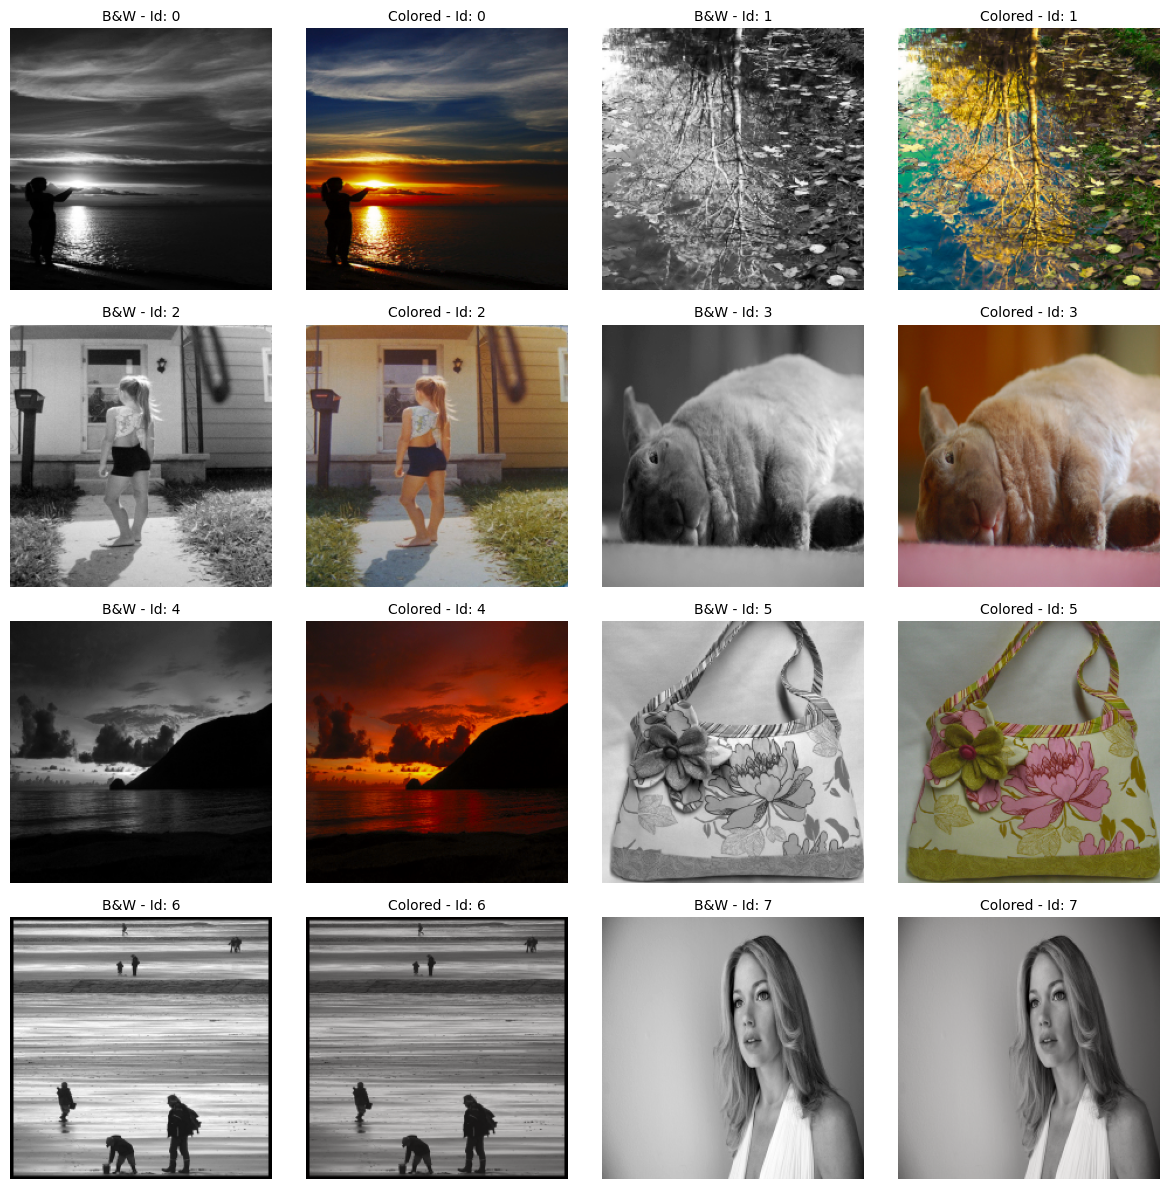

In [6]:
def tensor_to_numpy(tensor):
    return tensor.detach().cpu().numpy()

dataiter = iter(train_loader)
images, labels = next(dataiter)  # Carga un batch del DataLoader

# Configuración del plot
fig, axs = plt.subplots(4, 4, figsize=(12, 12))  # 4 filas, 4 columnas para 8 pares de imágenes

for i in range(8):  # Solo necesitamos 8 pares de imágenes, total 16 subplots
    row = i // 2  # Cada fila tiene 2 pares
    col = (i % 2) * 2  # Columna alterna para B&W y Colored (0, 2 para B&W; 1, 3 para Colored)

    l_image = tensor_to_numpy(images[i]).squeeze()  # [H, W], quita el canal si es 1
    ab_image = tensor_to_numpy(labels[i])  # [2, H, W]

    # Asegurarse de que los datos están en la escala correcta
    l_image = l_image * 100  # Escalar L de [0, 1] a [0, 100]
    ab_image = (ab_image - 0.5) * 255  # Escalar a y b de [-0.5, 0.5] a [-128, 127]

    # Imagen en escala de grises
    axs[row, col].imshow(l_image, cmap='gray')
    axs[row, col].set_title(f'B&W - Id: {i}', fontsize=10)
    axs[row, col].axis('off')  # Desactiva los ejes

    # Imagen coloreada
    img_lab = np.zeros((224, 224, 3), dtype=np.float32)
    img_lab[:,:,0] = l_image  # L canal
    img_lab[:,:,1:] = ab_image.transpose(1, 2, 0)  # a y b canales
    img_rgb = lab2rgb(img_lab)  # Convierte LAB a RGB
    axs[row, col + 1].imshow(img_rgb)
    axs[row, col + 1].set_title(f'Colored - Id: {i}', fontsize=10)
    axs[row, col + 1].axis('off')

plt.tight_layout()
plt.show()

In [7]:
# Define the CAE architecture to colorize images (greyscale to LAB)

class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        """
        encoder architecture explained:
        - input: 1x224x224
        - output: 8x28x28

        1. Conv2d: 1 input channel, 16 output channels, kernel size 3, stride 1, padding 1
        2. ReLU activation function
        3. MaxPool2d: kernel size 2, stride 2
        4. Conv2d: 16 input channels, 8 output channels, kernel size 3, stride 1, padding 1
        5. ReLU activation function
        6. MaxPool2d: kernel size 2, stride 2
        """
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        """
        decoder architecture explained:
        - input: 8x28x28
        - output: 2x224x224
        1. ConvTranspose2d: 8 input channels, 16 output channels, kernel size 3, stride 2, padding 1, output padding 1
        2. ReLU activation function
        3. ConvTranspose2d: 16 input channels, 2 output channels, kernel size 3, stride 2, padding 1, output padding 1
        4. Sigmoid activation function
        """
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 2, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
         
    def forward(self, x):
        z = self.encoder(x)
        x_re = self.decoder(z)
        return x_re

In [8]:
architecture = CAE()
summary(architecture, (1, 224, 224), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 16, 224, 224]             160
              ReLU-2         [32, 16, 224, 224]               0
         MaxPool2d-3         [32, 16, 112, 112]               0
            Conv2d-4          [32, 8, 112, 112]           1,160
              ReLU-5          [32, 8, 112, 112]               0
         MaxPool2d-6            [32, 8, 56, 56]               0
   ConvTranspose2d-7         [32, 16, 112, 112]           1,168
              ReLU-8         [32, 16, 112, 112]               0
   ConvTranspose2d-9          [32, 2, 224, 224]             290
          Sigmoid-10          [32, 2, 224, 224]               0
Total params: 2,778
Trainable params: 2,778
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 6.12
Forward/backward pass size (MB): 643.12
Params size (MB): 0.01
Estimated Tot

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


In [9]:
architecture = CAE()
file_name = "cae_1.0"
train_model(train_loader, architecture, file_name, epochs=20)

Number of parameters: 2778
Epoch 1


Epoch 1: 100%|██████████| 71/71 [00:35<00:00,  2.03it/s, loss=0.0049]


Epoch 2


Epoch 2: 100%|██████████| 71/71 [00:42<00:00,  1.65it/s, loss=0.0042]


Epoch 3


Epoch 3: 100%|██████████| 71/71 [00:40<00:00,  1.74it/s, loss=0.0020]


Epoch 4


Epoch 4: 100%|██████████| 71/71 [00:36<00:00,  1.93it/s, loss=0.0037]


Epoch 5


Epoch 5: 100%|██████████| 71/71 [00:36<00:00,  1.97it/s, loss=0.0031]


Epoch 6


Epoch 6: 100%|██████████| 71/71 [00:33<00:00,  2.10it/s, loss=0.0050]


Epoch 7


Epoch 7: 100%|██████████| 71/71 [00:38<00:00,  1.83it/s, loss=0.0056]


Epoch 8


Epoch 8: 100%|██████████| 71/71 [00:42<00:00,  1.65it/s, loss=0.0069]


Epoch 9


Epoch 9: 100%|██████████| 71/71 [00:36<00:00,  1.92it/s, loss=0.0029]


Epoch 10


Epoch 10: 100%|██████████| 71/71 [00:37<00:00,  1.87it/s, loss=0.0044]


Epoch 11


Epoch 11: 100%|██████████| 71/71 [00:38<00:00,  1.86it/s, loss=0.0042]


Epoch 12


Epoch 12: 100%|██████████| 71/71 [00:37<00:00,  1.87it/s, loss=0.0022]


Epoch 13


Epoch 13: 100%|██████████| 71/71 [00:37<00:00,  1.91it/s, loss=0.0029]


Epoch 14


Epoch 14: 100%|██████████| 71/71 [00:35<00:00,  1.99it/s, loss=0.0097]


Epoch 15


Epoch 15: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s, loss=0.0029]


Epoch 16


Epoch 16: 100%|██████████| 71/71 [00:44<00:00,  1.58it/s, loss=0.0099]


Epoch 17


Epoch 17: 100%|██████████| 71/71 [00:35<00:00,  2.01it/s, loss=0.0020]


Epoch 18


Epoch 18: 100%|██████████| 71/71 [00:39<00:00,  1.80it/s, loss=0.0034]


Epoch 19


Epoch 19: 100%|██████████| 71/71 [00:42<00:00,  1.67it/s, loss=0.0037]


Epoch 20


Epoch 20: 100%|██████████| 71/71 [00:45<00:00,  1.55it/s, loss=0.0062]


Finished Training


In [10]:
# Define transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

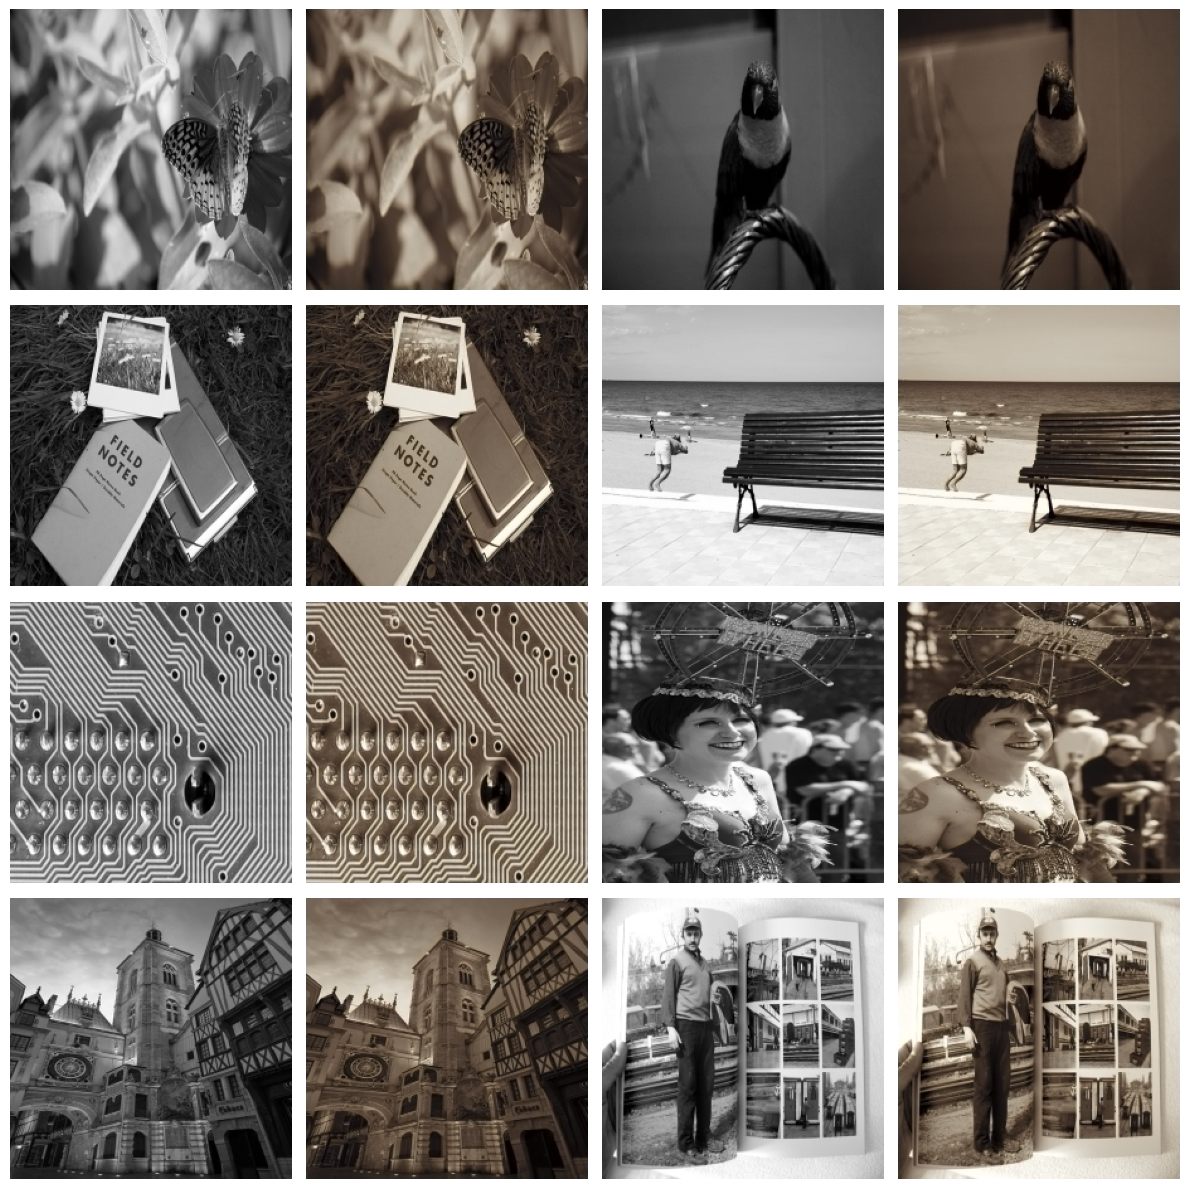

In [13]:
# # Cargar el dataset
# test_dataset = datasets.ImageFolder(root='path/to/your/test/dataset', transform=transform)
# test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# Cargar el modelo entrenado
model = CAE()
checkpoint = torch.load('cae_1.0_0.001_full.pt', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Evaluación del modelo
dataiter = iter(test_loader)
images, _ = next(dataiter)
images = images.to(device)
outputs = model(images)

# Visualización de resultados
fig, axs = plt.subplots(4, 4, figsize=(12, 12))
for i in range(8):
    # Imagen en escala de grises
    gray_image = tensor_to_numpy(images[i]).squeeze()
    axs[i//2, (i % 2) * 2].imshow(gray_image, cmap='gray')
    axs[i//2, (i % 2) * 2].axis('off')

    # Imagen colorizada (predicción)
    ab_image = tensor_to_numpy(outputs[i])
    img_lab = np.zeros((224, 224, 3), dtype=np.float32)
    img_lab[:,:,0] = gray_image * 100  # L canal
    img_lab[:,:,1:] = (ab_image.transpose(1, 2, 0) - 0.5) * 255  # a y b canales
    img_rgb = lab2rgb(img_lab)
    axs[i//2, (i % 2) * 2 + 1].imshow(img_rgb)
    axs[i//2, (i % 2) * 2 + 1].axis('off')
plt.tight_layout()
plt.show()

/var/folders/5t/gv304q1555352rgb4sklkh4m0000gn/T/ipykernel_24358/2605971915.py:11: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 215 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img_lab)
/var/folders/5t/gv304q1555352rgb4sklkh4m0000gn/T/ipykernel_24358/2605971915.py:11: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2153 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img_lab)
/var/folders/5t/gv304q1555352rgb4sklkh4m0000gn/T/ipykernel_24358/2605971915.py:11: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 86 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img_lab)
/var/folders/5t/gv304q1555352rgb4sklkh4m0000gn/T/ipykernel_24358/2605971915.py:11: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 192 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img_lab)
/var/folders/5t/gv304q155535

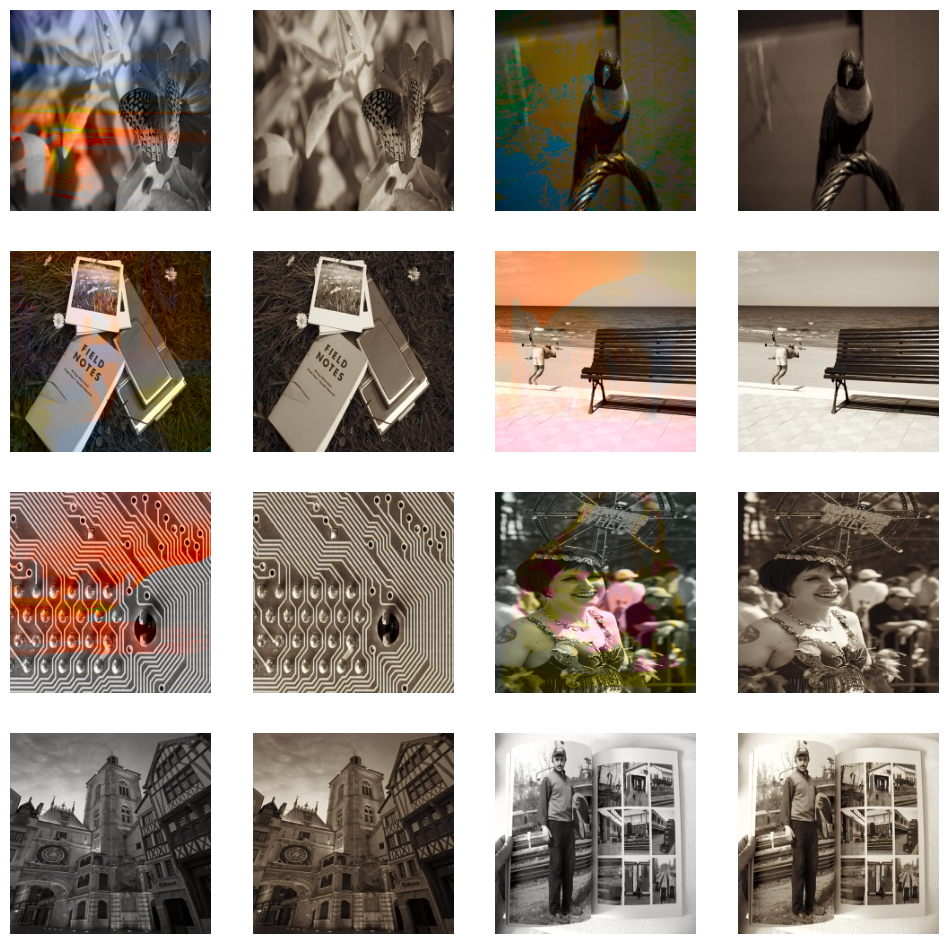

In [14]:
# como el código anterior pero ahora comparo la imagen original (en color) con la imagen coloreada

# Visualización de resultados
fig, axs = plt.subplots(4, 4, figsize=(12, 12))
for i in range(8):
    # Imagen en color
    color_image = tensor_to_numpy(labels[i])
    img_lab = np.zeros((224, 224, 3), dtype=np.float32)
    img_lab[:,:,0] = tensor_to_numpy(images[i]).squeeze() * 100  # L canal
    img_lab[:,:,1:] = (color_image.transpose(1, 2, 0) - 0.5) * 255  # a y b canales
    img_rgb = lab2rgb(img_lab)
    axs[i//2, (i % 2) * 2].imshow(img_rgb)
    axs[i//2, (i % 2) * 2].axis('off')

    # Imagen colorizada (predicción)
    ab_image = tensor_to_numpy(outputs[i])
    img_lab = np.zeros((224, 224, 3), dtype=np.float32)
    img_lab[:,:,0] = tensor_to_numpy(images[i]).squeeze() * 100  # L canal
    img_lab[:,:,1:] = (ab_image.transpose(1, 2, 0) - 0.5) * 255  # a y b canales
    img_rgb = lab2rgb(img_lab)
    axs[i//2, (i % 2) * 2 + 1].imshow(img_rgb)
    axs[i//2, (i % 2) * 2 + 1].axis('off')


/var/folders/5t/gv304q1555352rgb4sklkh4m0000gn/T/ipykernel_24358/1698839993.py:16: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 7589 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img_lab)
/var/folders/5t/gv304q1555352rgb4sklkh4m0000gn/T/ipykernel_24358/1698839993.py:16: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 23198 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img_lab)
/var/folders/5t/gv304q1555352rgb4sklkh4m0000gn/T/ipykernel_24358/1698839993.py:16: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 18966 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img_lab)
/var/folders/5t/gv304q1555352rgb4sklkh4m0000gn/T/ipykernel_24358/1698839993.py:16: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 4715 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img_lab)
/var/folders/5t/gv304q

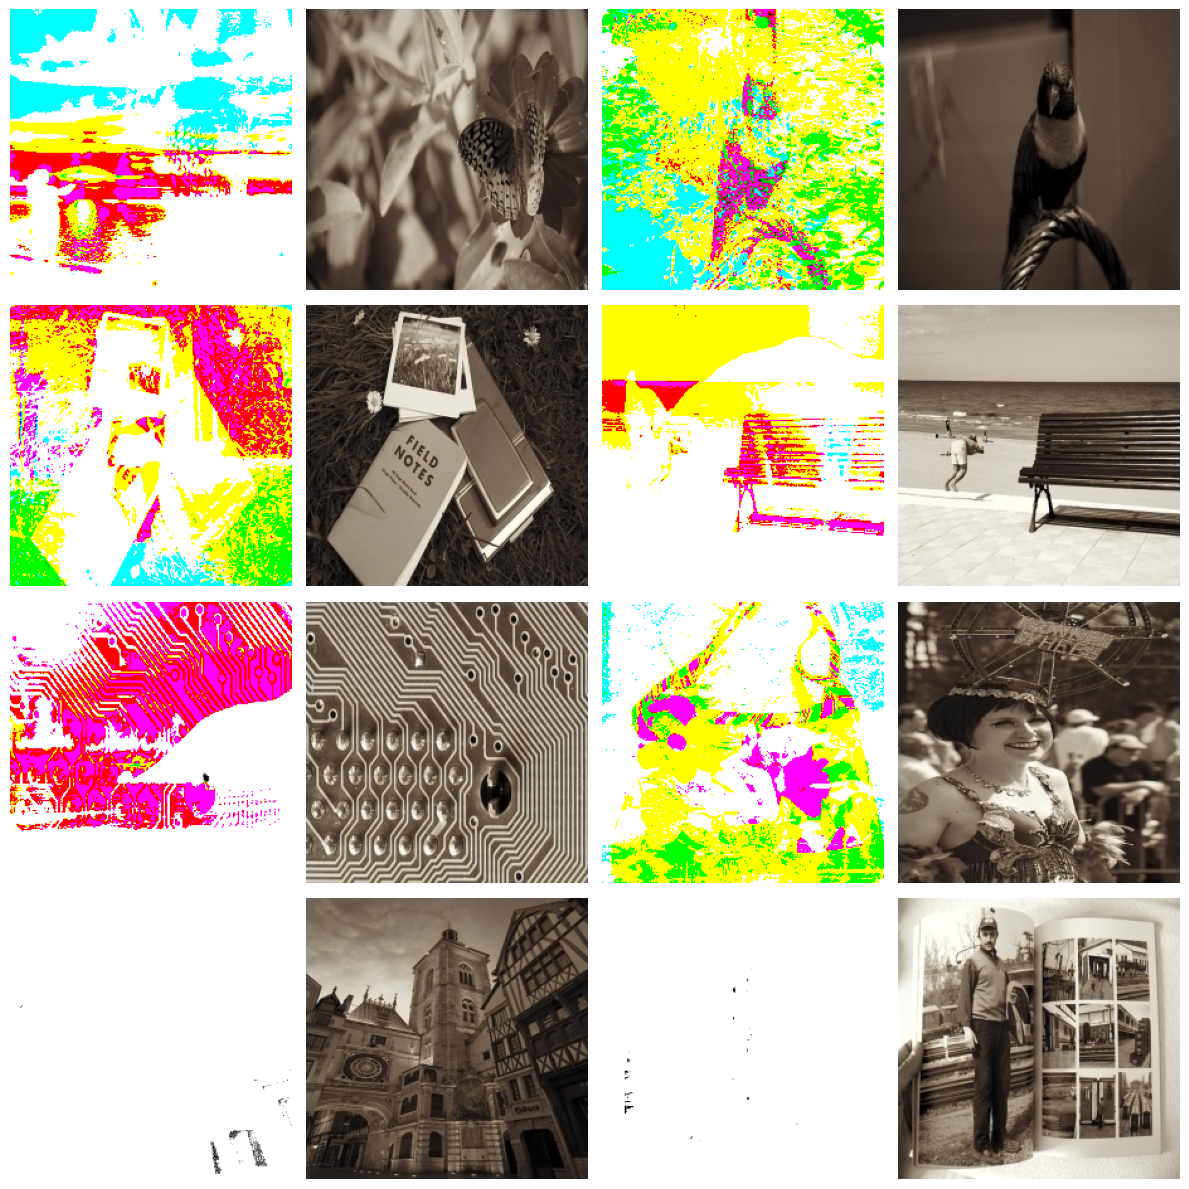

In [24]:
# Visualización de resultados
fig, axs = plt.subplots(4, 4, figsize=(12, 12))
for i in range(8):
    l_image = tensor_to_numpy(images[i]).squeeze()  # [H, W], quita el canal si es 1
    ab_image = tensor_to_numpy(labels[i])  # [2, H, W]

    # Asegurarse de que los datos están en la escala correcta
    l_image = l_image * 100  # Escalar L de [0, 1] a [0, 100]
    ab_image = (ab_image - 0.5) * 255  # Escalar a y b de [-0.5, 0.5] a [-128, 127]

    # Imagen en color (original)
    color_image = ab_image
    img_lab = np.zeros((224, 224, 3), dtype=np.float32)
    img_lab[:,:,0] = l_image.squeeze() * 100  # L canal
    img_lab[:,:,1:] = (color_image.transpose(1, 2, 0) * 255) - 128  # a y b canales
    img_rgb = lab2rgb(img_lab)
    axs[i//2, (i % 2) * 2].imshow(img_rgb)
    axs[i//2, (i % 2) * 2].axis('off')

    # Imagen colorizada (predicción)
    ab_image_re = tensor_to_numpy(outputs[i])
    img_lab = np.zeros((224, 224, 3), dtype=np.float32)
    img_lab[:,:,0] = l_image
    img_lab[:,:,1:] = (ab_image_re.transpose(1, 2, 0) * 255) - 128  # a y b canales
    img_rgb = lab2rgb(img_lab)
    axs[i//2, (i % 2) * 2 + 1].imshow(img_rgb)
    axs[i//2, (i % 2) * 2 + 1].axis('off')

plt.tight_layout()
plt.show()